In [25]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from umap import UMAP
from sklearn.cluster import KMeans
import time
from tqdm import tqdm

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.nn.functional as F

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
data_dir = '/home/squid/Desktop/Octopi_data'

pos_images = np.load(os.path.join(data_dir, 'combined_images_parasite.npy'))
neg_images = np.load(os.path.join(data_dir, 'neg_combined_images.npy'))
pos_images.shape, neg_images.shape



((76126, 4, 31, 31), (744187, 4, 31, 31))

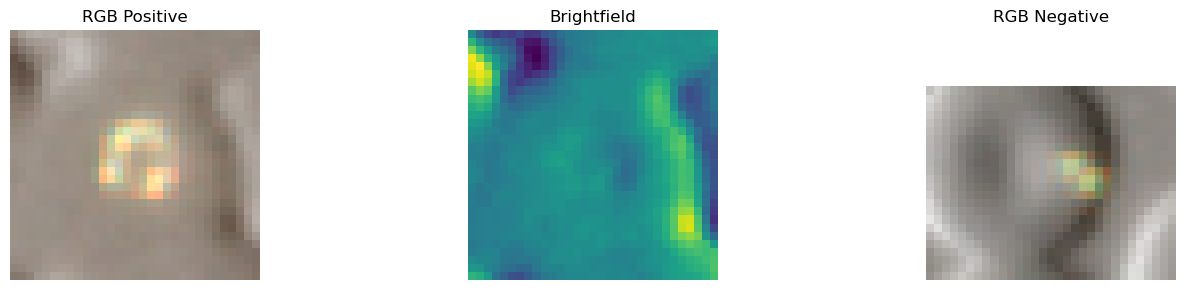

In [4]:
# image (4,31,31), rgb + brightfield
# im = pos_images[0][:3,:,:].transpose(1,2,0) # expects (W,H,C)

fig, axes = plt.subplots(1, 3, figsize=(15, 3))

axes[0].imshow(pos_images[0].transpose(1,2,0))
axes[1].imshow(pos_images[0][3,:,:])
axes[2].imshow(neg_images[0].transpose(1,2,0))
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title(f'RGB Positive')
axes[1].set_title(f'Brightfield')
axes[2].set_title(f'RGB Negative')

plt.tight_layout()
plt.show()

Applying UMAP


/home/squid/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/squid/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


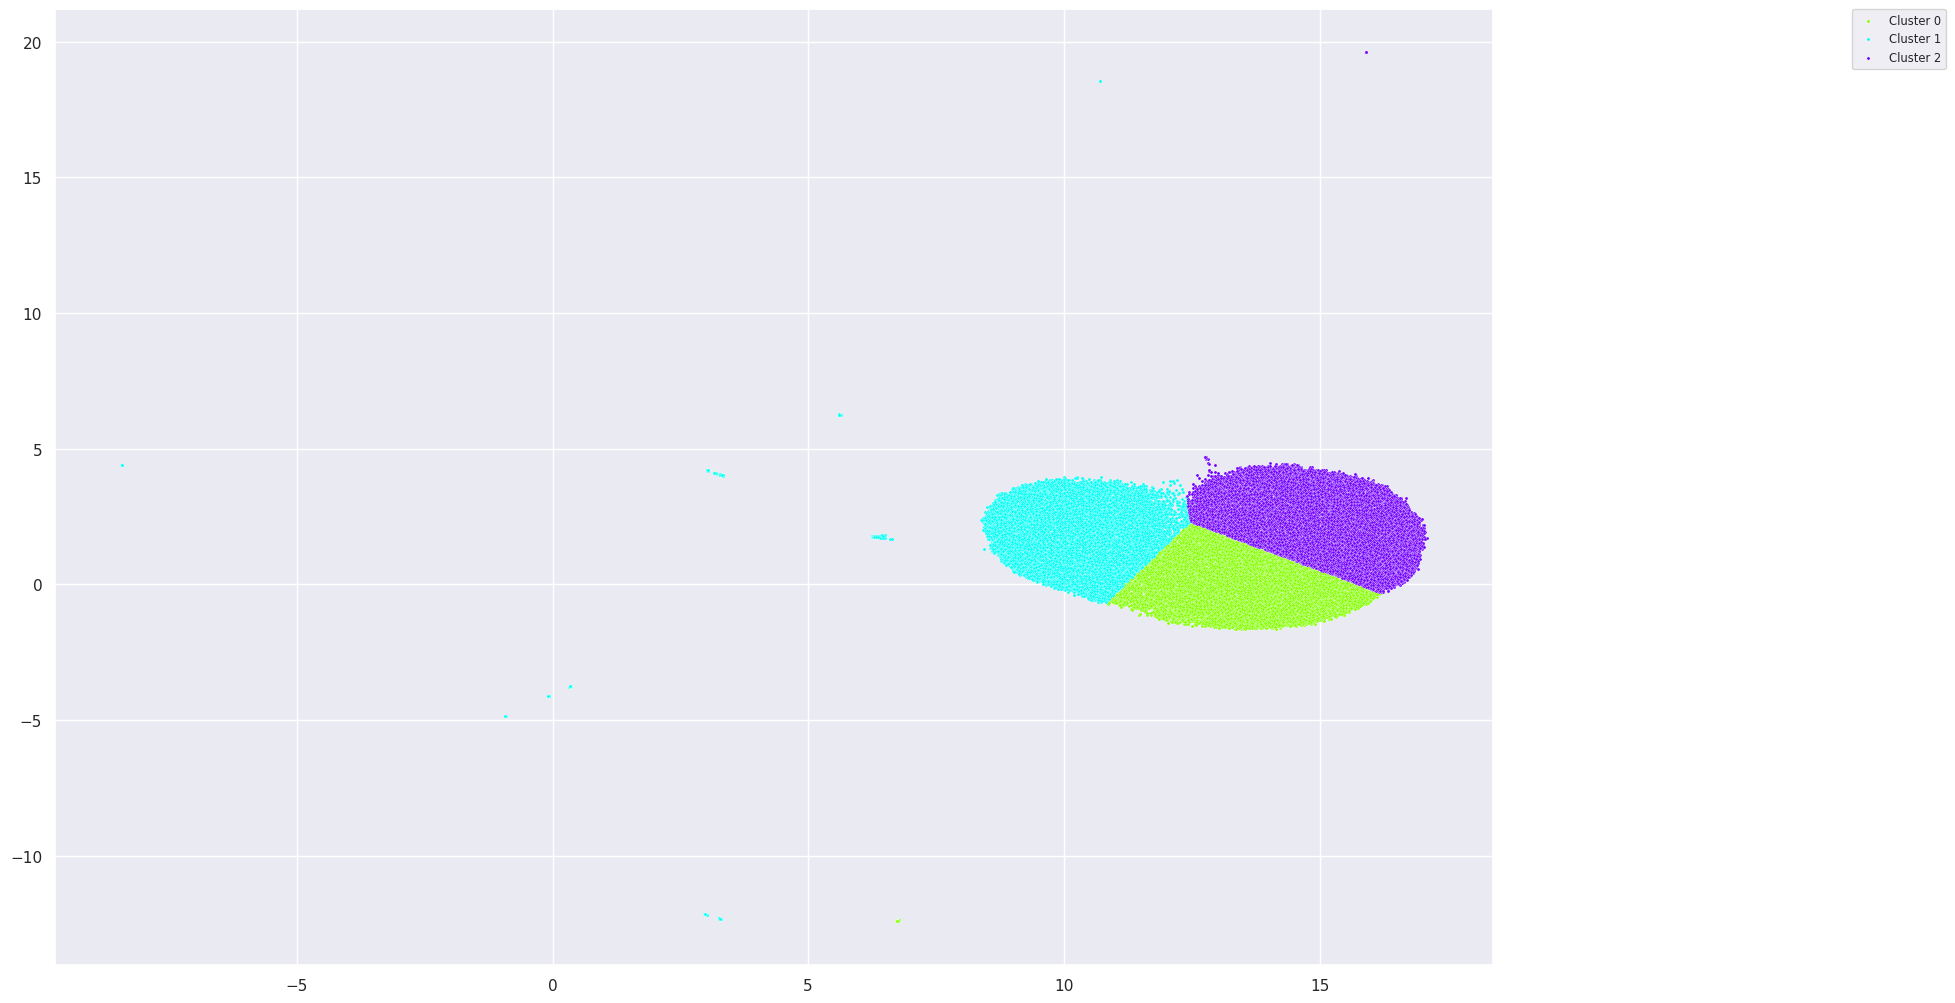

In [5]:
# cluster to find stages/morphologies
n_samples = pos_images.shape[0]
data = pos_images.reshape(n_samples, -1)

print('Applying UMAP')
reducer = UMAP(n_components=2, n_neighbors=30, min_dist=0.1, metric='euclidean', learning_rate=1.0, n_epochs=500, spread=1.0, random_state=42)
embedding = reducer.fit_transform(data)

n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embedding)

# visualize
sns.set(font_scale=1)
plt.figure(figsize=(20, 12))
palette = sns.color_palette("hsv", n_clusters)
cluster_labels = ['Cluster {}'.format(i) for i in range(n_clusters)]
for i in range(n_clusters):
    sns.scatterplot(x=embedding[clusters == i, 0], y=embedding[clusters == i, 1], color=palette[i], label=cluster_labels[i], s=5)

plt.legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0., fontsize='x-small')
plt.tight_layout(rect=[0, 0, 1, 0.85])
# plt.savefig(f"umap_clusters_{time.time()}.png", dpi=300)
plt.show()



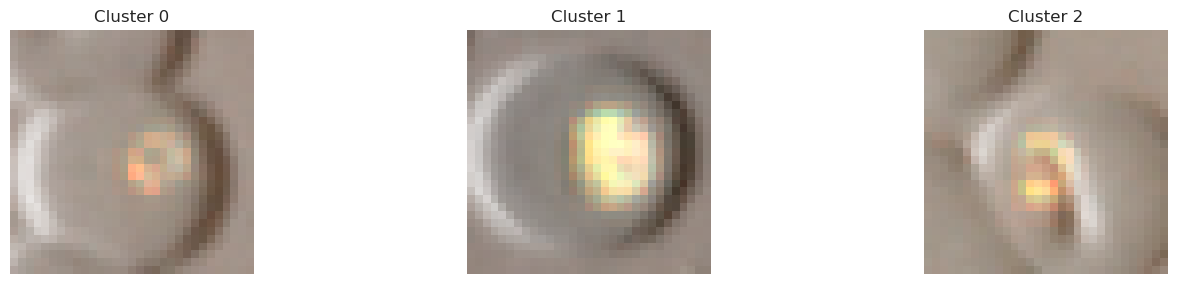

In [6]:
# plot sample from each cluster
sample_indices = []
for i in range(n_clusters):
    cluster_indices = np.where(clusters == i)[0]
    sample_indices.append(np.random.choice(cluster_indices))

fig, axes = plt.subplots(1, n_clusters, figsize=(15, 3))
for ax, idx in zip(axes, sample_indices):
    ax.imshow(pos_images[idx].transpose(1, 2, 0))
    ax.axis('off')
    ax.set_title(f'Cluster {clusters[idx]}')

plt.tight_layout()
plt.show()

get baseline Resnet performance

In [7]:
import torch
import torch.nn as nn
import torchvision.models

models_dict = {'resnet18': torchvision.models.resnet18,
               'resnet34': torchvision.models.resnet34,
               'resnet50': torchvision.models.resnet50,
               'resnet101': torchvision.models.resnet101,
               'resnet152': torchvision.models.resnet152}

class ResNet(nn.Module):
    def __init__(self, model='resnet18',n_channels=4,n_filters=64,n_classes=1,kernel_size=3,stride=1,padding=1):
        super().__init__()
        self.n_classes = n_classes
        self.base_model = models_dict[model](pretrained=True)
        self._feature_vector_dimension = self.base_model.fc.in_features
        self.base_model.conv1 = nn.Conv2d(n_channels, n_filters, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])
        self.fc = nn.Linear(self._feature_vector_dimension, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.base_model(x)
        features = x.view(x.size(0), -1)
        return self.fc(features)

    def extract_features(self,x):
        x = self.base_model(x)
        return x.view(x.size(0), -1)

    def get_predictions(self,x):
        x = self.base_model(x)
        features = x.view(x.size(0), -1)
        output = self.fc(features)
        if self.n_classes == 1:
            return torch.sigmoid(output)
        else:
            return torch.softmax(output,dim=1)

In [13]:
# train test split within a single positive cluster (use others for ood)
pos_train_images = pos_images[np.concatenate([np.where(clusters == 0)[0]])]
train_size = len(pos_train_images)
neg_train_images = neg_images[:train_size] # only use subset for toy experiment
pos_labels = np.ones(train_size)
neg_labels = np.zeros(train_size)

print("tiny dataset: ", 2*train_size)

combined_images = np.concatenate((pos_train_images, neg_train_images), axis=0)
combined_labels = np.concatenate((pos_labels, neg_labels), axis=0)

X_train, X_test, y_train, y_test = train_test_split(combined_images, combined_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

datasets = {
    "train": TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)),
    "val": TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)),
    "test": TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
}
loaders = {x: DataLoader(datasets[x], batch_size=64, shuffle=(x == "train")) for x in datasets}

tiny dataset:  48648


In [14]:

model = ResNet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

/home/squid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/squid/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
num_epochs = 10
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        correct = 0
        total = 0

        for i,data in enumerate(tqdm(loaders[phase])):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(images)
                loss = F.binary_cross_entropy_with_logits(outputs.squeeze(), labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_accuracy = 100 * correct / total
        print(f'{phase} - Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

100%|██████████| 487/487 [02:10<00:00,  3.72it/s]


train - Epoch 1: Loss: 0.0092, Accuracy: 99.74%


100%|██████████| 122/122 [00:05<00:00, 23.37it/s]


val - Epoch 1: Loss: 0.0063, Accuracy: 99.82%


100%|██████████| 487/487 [02:16<00:00,  3.58it/s]


train - Epoch 2: Loss: 0.0057, Accuracy: 99.80%


100%|██████████| 122/122 [00:05<00:00, 23.33it/s]


val - Epoch 2: Loss: 0.0312, Accuracy: 98.93%


100%|██████████| 487/487 [02:14<00:00,  3.62it/s]


train - Epoch 3: Loss: 0.0049, Accuracy: 99.85%


100%|██████████| 122/122 [00:05<00:00, 23.27it/s]


val - Epoch 3: Loss: 0.0071, Accuracy: 99.76%


  7%|▋         | 34/487 [00:10<02:14,  3.38it/s]


KeyboardInterrupt: 